<h2 align=center> Building a Text Matching System for Question Matching </h2>

<h4 align=center> APPLIED NATURAL LANGUAGE PROCESSING</h4>



### Note: After running the whole notebook,
#### 1. For TFIDF Model, to get top matches (2 or 5), use code:
- top5 = get_similarity_tfidf("sentence",5) 
- print_top_k(top5)

#### 2. For Average word Model, use code:
- top5 = get_similarity_avg_word("sentence" , 5 )
- print_top_k(top5)

#### 3. For Smooth Inverse Frequency  Model, use code:
- top5 = get_similarity_SIF("sentence" , 5 )
- print_top_k(top5)

##  Importing Libraries

In [ ]:
# imports
import numpy as np 
import pandas as pd
import sklearn
import operator
import sys
from sklearn.model_selection import train_test_split

import nltk
from nltk import stem 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import random
import re
import math
from math import sqrt
from math import log
from math import log10
from statistics import mean
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

import collections
from collections import Counter
import itertools
from itertools import islice
from itertools import chain
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# nltk downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Load and Explore the Data

In [ ]:
# data loading
df = pd.read_csv('data.tsv', sep='\t',error_bad_lines=False)
df.head(10) 

b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0
5,119056,193387,193388.0,How not to feel guilty since I am Muslim and I...,"I don't beleive I am bulimic, but I force thro...",0.0
6,356863,422862,96457.0,How is air traffic controlled?,How do you become an air traffic controller?,0.0
7,106969,147570,787.0,What is the best self help book you have read?...,What are the top self help books I should read?,1.0
8,196763,297539,297540.0,Can I enter University of Melbourne if I could...,University of the Philippines: If I take a sec...,0.0
9,256389,37932,371478.0,Do you need a passport to go to Jamaica from t...,How can I move to Jamaica?,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363192 entries, 0 to 363191
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            363192 non-null  object 
 1   qid1          363192 non-null  object 
 2   qid2          363185 non-null  float64
 3   question1     363181 non-null  object 
 4   question2     363180 non-null  object 
 5   is_duplicate  363180 non-null  float64
dtypes: float64(2), object(4)
memory usage: 16.6+ MB


In [ ]:
# change data types
df["id"] = pd.to_numeric(df["id"],errors='coerce')
df["qid1"] = pd.to_numeric(df["qid1"],errors='coerce') 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363192 entries, 0 to 363191
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            363182 non-null  float64
 1   qid1          363189 non-null  float64
 2   qid2          363185 non-null  float64
 3   question1     363181 non-null  object 
 4   question2     363180 non-null  object 
 5   is_duplicate  363180 non-null  float64
dtypes: float64(4), object(2)
memory usage: 16.6+ MB


In [ ]:
# check unique values
df.nunique()

id              363182
qid1            266111
qid2            273126
question1       265929
question2       272961
is_duplicate         2
dtype: int64

In [ ]:
df.shape

(363192, 6)

In [ ]:
# Check for null values

null_tr = df.isnull().sum()
print("Null values in set: ")
print(null_tr)
print()

Null values in set: 
id              10
qid1             3
qid2             7
question1       11
question2       12
is_duplicate    12
dtype: int64



In [ ]:
# drop null values
df = df.dropna()
df.shape

(363177, 6)

In [ ]:
duplicateRowsQ1 = df[df.duplicated([ 'question1'])]
print(duplicateRowsQ1.shape)

duplicateRowsQ2 = df[df.duplicated([ 'question2'])]
print(duplicateRowsQ2.shape)

(97251, 6)
(90218, 6)


In [ ]:
# drop rows with duplicated questions

df = df.drop_duplicates(subset = ['question1'], keep = 'last').reset_index(drop = True)
print("Shape of dataframe after dropping duplicated rows in question 1: ", df.shape)

df = df.drop_duplicates(subset = ['question2'], keep = 'last').reset_index(drop = True)
print("Shape after dropping duplicated rows in question 1 and 2 both : ", df.shape) 

Shape of dataframe after dropping duplicated rows in question 1:  (265926, 6)
Shape after dropping duplicated rows in question 1 and 2 both :  (232203, 6)


In [ ]:
# distribution of label
df['is_duplicate'].value_counts()

0.0    169095
1.0     63108
Name: is_duplicate, dtype: int64

In [ ]:
# Check for null values
null_tr = df.isnull().sum()
print("Null values in set: ")
print(null_tr)
print()

Null values in set: 
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64



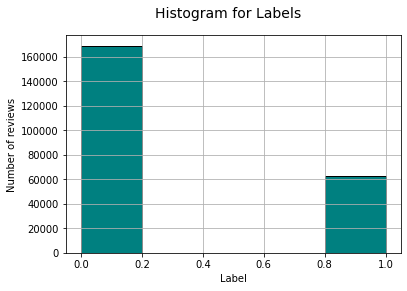

In [ ]:
# plot distribution of label
df['is_duplicate'].hist(edgecolor = 'black',bins=5,facecolor = 'teal')
plt.suptitle("Histogram for Labels",size = 14)
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.show()

- Test Dataset

In [ ]:
df_allduplicate = df[df['is_duplicate'] == 1]
df_test = df_allduplicate[0:100] 
df_test

,id,qid1,qid2,question1,question2,is_duplicate
1,402555.0,536040.0,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
6,11568.0,22332.0,22333.0,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?,1.0
11,33995.0,62359.0,62360.0,How does an IQ test work and what is determine...,How does IQ test works?,1.0
12,244506.0,357159.0,357160.0,Is it safe to use Xiaomi mobile phones?,Is it safe or unsafe to use Xiaomi Products?,1.0
14,375073.0,506056.0,506057.0,What are the best books on cosmology?,Which is the best book for cosmology?,1.0
...,...,...,...,...,...,...
379,17002.0,32363.0,32364.0,What is it like to work at Factual?,What is it like to work at Factual in 2016?,1.0
385,179873.0,275905.0,275906.0,How do I recover data from an external hard disk?,How can I recover data from an external hard d...,1.0
390,236758.0,347752.0,347753.0,What is the perfect website that lists all for...,What is the perfect website that lists all typ...,1.0
392,72098.0,123946.0,123947.0,Can I install Mac OS on my Dell laptop? How?,How do I install Mac OS on a Dell laptop?,1.0


In [ ]:
ques1_list  = df_test['question1'].tolist()

print("Length of question 1 list(first 100 with is_dup = 1): ", len(ques1_list))
print("Unique question 1 Ids: ", df_test['qid1'].nunique()) # all unique ids

Length of question 1 list(first 100 with is_dup = 1):  100
Unique question 1 Ids:  100


## 1. Data Prepocessing

- Stop word Removal, Stemming/Lemmatization, Puntuation removal is done
- Stemming is done for TF-IDF Method while for sentence embedding based methods, Lemmatization is used

In [ ]:
# function to remove puntuation
def remove_puntuation(text):
    text = [word for word in text if word.isalpha()] #  remove all puntuation and numbers
    return text 

# function to remove stop word from text
def remove_stopwords(text):
    stop_words = list(stopwords.words('english')) # store nltk stopwords
    text = [word for word in text if not word in stop_words] 
    return text 

# function to perform stemming
def stemming(text):
  stemer = stem.porter.PorterStemmer()
  text = [stemer.stem(token) for token in text] 
  return text 

# function to perform lemmatization
def lemmatization (text):
    lemmatizer = stem.WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(token) for token in text]
    return text 

# function to perform text preprocessing (stemming)
def clean_corpus(text):
    
    text = text.lower()                # lower case  
    token = word_tokenize(text)         # tokenise
  
    token = remove_stopwords(token)    # remove stopwords
    token = remove_puntuation(token)   # remove puntuation 

    token = stemming(token) 

    all_tokens = " ".join(token)       # join all tokens

    return all_tokens

# function to perform text preprocessing (lemmatization and no stemming)
def clean_corpus_2(text):
    
    text = text.lower()                # lower case  
    token = word_tokenize(text)         # tokenise
  
    token = remove_stopwords(token)    # remove stopwords
    token = remove_puntuation(token)   # remove puntuation 
    token = lemmatization(token)       # lemmatize

    all_tokens = " ".join(token)       # join all tokens

    return all_tokens

In [ ]:
# preprocess training data
df['processed_ques2'] = df.question2.apply(lambda x: clean_corpus(x))

In [ ]:
#look at some preprocessed text
print(df['processed_ques2'].values[6])

best book tensor calculu


In [ ]:
df["question2"].values[6]

'Which is the best book for tensor calculus?'

In [ ]:
df['processed_ques2'][0:15]

0                             level preprat enough exam
1                                         control horni
2     would second airport sydney australia need rai...
3     beleiv bulim forc throw atleast day eat someth...
4                             becom air traffic control
5                              qualifi sap erp key user
6                              best book tensor calculu
7                                  contact donald knuth
8                           die roll probabl number top
9                                      best backend app
10            type govern franc current benefit countri
11                                         iq test work
12                        safe unsaf use xiaomi product
13                    creativ idea arrang fresher parti
14                                   best book cosmolog
Name: processed_ques2, dtype: object

In [ ]:
# function to get word count of a dataset
def word_count(dataset):
    
    unique_words = [] 
    
    for row in dataset:
        for word in row.split(" "):
            if len(word) > 2 and word not in unique_words:
                unique_words.append(word) # Add each unique word of length > 2 to the list
            
    unique_words.sort()
    vocab = {j:i for i,j in enumerate(unique_words)} # Enumerate the list, i.e., give consecutive numbers to each item, store in a dict
    return vocab

In [ ]:
#total number of unique words in question2 with length of word > 2
unique_words_ques2 = word_count(df['processed_ques2'])
print("Number of unique words in question2: ",len(unique_words_ques2))  

Number of unique words in question2:  35937


In [ ]:
# function to remove words which have a count less than N
def min_df(col , N):
  v = col.str.split().tolist()              # split words into list
  c = Counter(chain.from_iterable(v))       # compute word frequency
  col = [' '.join([j for j in i if c[j] > N]) for i in v] #  join and reassign      
  return col

# function to remove words which have a count greater than N
def max_df(col , N):
  v = col.str.split().tolist()             # split words into list
  c = Counter(chain.from_iterable(v))      # compute word frequency
  col = [' '.join([j for j in i if c[j] < N]) for i in v] #  join and reassign      
  return col

In [ ]:
df["processed_ques2"] = max_df(df["processed_ques2"], 5000)  #remove words with count greater than 5k
df["processed_ques2"] = min_df(df["processed_ques2"], 1) 

#total number of unique words in question2 after preprocessing
unique_words_ques2 = word_count(df['processed_ques2'])
print("Number of unique words in question2: ",len(unique_words_ques2))   #15479

Number of unique words in question2:  19845


In [ ]:
df['processed_ques2'][0:20]

0                             level preprat enough exam
1                                         control horni
2     second airport sydney australia need rail link...
3     bulim forc throw atleast day eat someth feel g...
4                             becom air traffic control
5                              qualifi sap erp key user
6                                   book tensor calculu
7                                  contact donald knuth
8                           die roll probabl number top
9                                           backend app
10            type govern franc current benefit countri
11                                              iq test
12                            safe unsaf xiaomi product
13                    creativ idea arrang fresher parti
14                                        book cosmolog
15                                 staten island racist
16                             beauti hous around world
17                                              

In [ ]:
ques2_list = df['processed_ques2'].tolist()
len(ques2_list)

232203

In [ ]:
# remove empty questions 
count = 0
i = 0

for line in ques2_list: 
  if line == "":
    count = count+ 1
    del ques2_list[i] # delete questions which are empty strings  
    
  i = i +1

print("Total number of empty questions in question2: ",count)
len(ques2_list)

Total number of empty questions in question2:  804


231399

## 2. TF IDF

In [ ]:
vocab = word_count(df['processed_ques2'][:50000]) 
print("Vocabulary length: ",len(vocab))  #17899

Vocabulary length:  14868


In [ ]:
# function to calculate Inverse document frequesny
def get_doc_freq(data,word):
    
    freq = 0
    for row in data:
        if word in row:
            freq = freq + 1
    return freq

# function to generate TF-IDF matrix
def transform(data, vocab):
    
    rows = []              # stores which row number/question a word belongs to
    each_word_freq = []   # stores the frequency of a word in the vocabulary 
    result = []           # stores TF IDF value of a word
    
    for indx, row in enumerate(data): # for each Qeuestion 2 in the dataset

        sentence_word_freq = dict(Counter(row.split())) 

        for word, freq in sentence_word_freq.items(): 
            if len(word) < 2:                     # keep words with length > 2
                continue 

            vocab_idx = vocab.get(word, -1)      # get the frequency of a word in the vocab,  if the word doesn't exits, return -1
            
            if vocab_idx != -1:

                rows.append(indx)   
                each_word_freq.append(vocab_idx)

                doc_freq = get_doc_freq(data,word) # document frequency of a word
           
                TF = freq / len(row.split())        # term frequency
                IDF = log10(len(data)/doc_freq)     # inverse document frequency
                
                val = TF * IDF 
                result.append(val)

    x = len(data)
    y = len(vocab)

    # For TFIDF Matrix, row index = row number/question a word belongs to, column index = each word frequency           
    return csr_matrix( (result, (rows, each_word_freq)), shape=(x,y) ) 

In [ ]:

tfidf_cols = [] #store the word which represents each column in TFIDF matrix  
 
for key, val in vocab.items():
  tfidf_cols.append(key) 

print(len(tfidf_cols))

14868


In [ ]:
tf_idf_vect = transform(ques2_list[0:50000] , vocab) # get TFIDF matrix

print("TF-IDF shape: " , str(tf_idf_vect.shape))
print(tf_idf_vect)                              

TF-IDF shape:  (50000, 14868)
  (0, 4259)	0.6715331949077117
  (0, 4464)	0.459807859534718
  (0, 7543)	0.6366704149882406
  (0, 10295)	1.0
  (1, 2846)	1.2529227029907786
  (1, 6051)	1.926935982160881
  (2, 273)	0.310790539730952
  (2, 910)	0.26234230429434885
  (2, 3032)	0.21284270644541214
  (2, 7628)	0.2552841968657781
  (2, 8222)	0.3744727494896694
  (2, 8893)	0.19385475209128067
  (2, 10705)	0.2866461091629783
  (2, 11715)	0.2661543506395395
  (2, 12971)	0.6017547848615011
  (3, 861)	0.3838044317833051
  (3, 1791)	0.3838044317833051
  (3, 3286)	0.15923057113172437
  (3, 4026)	0.13249304761267913
  (3, 4695)	0.17194863420610598
  (3, 4937)	0.21569401303702432
  (3, 5589)	0.3130634090211557
  (3, 12310)	0.29854515057865466
  (3, 12314)	0.2275518501751623
  (3, 13154)	0.18851432303403134
  :	:
  (49994, 7713)	0.49346887081363744
  (49994, 10943)	1.0
  (49995, 3789)	1.0120707242181481
  (49995, 8792)	0.7083129122027666
  (49995, 13509)	1.2329900014453394
  (49996, 4834)	0.4886600009635

In [ ]:
tf_idf_array = tf_idf_vect.toarray()
print(tf_idf_array )
print(tf_idf_array.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(50000, 14868)


In [ ]:
# function to generate inverted index
def generate_inverted_index(data):

    inv_idx_dict = {}

    for index, rows in enumerate(data):
        for word in rows.split():

          if len(word) > 2:                        # discard words of length less than 2
            if word not in inv_idx_dict.keys() : 
                inv_idx_dict[word] = [index]      # add word as key in dict

            elif index not in inv_idx_dict[word] :
                inv_idx_dict[word].append(index)  # add location of document(question2) as value 

    return inv_idx_dict

In [ ]:
inverted_index = generate_inverted_index(ques2_list[0:50000])
len(inverted_index)

14878

In [ ]:
# get the position of the column representing the word 'term' in TFIDF matrix
def find_term_pos(term):
  pos = -99
  for i in [i for i,x in enumerate(tfidf_cols) if x == term]:
    pos = i 
  return pos

In [ ]:
print(find_term_pos("safe"))
print(find_term_pos("iq")) # there is no word name 'iq' in the TFIDF matrix representation

11447
-99


In [ ]:
# function to caculate topk similar questions , returns question number and similarity score
def get_similarity_tfidf(ques1_sentence, k):

  doc_sim = {}
  ques1_sentence = clean_corpus(ques1_sentence) # preprocess input sentence
  tokens = word_tokenize(ques1_sentence)

  for term in tokens:
    if term in inverted_index.keys() :

      docs = inverted_index[term]     # get list of docs in which term is present   
      term_pos = find_term_pos(term)  # find position of term in TFIDF matrix

      if term_pos != -99:            #  if term has a TFIDF value
        for doc in docs:
          doc_score = tf_idf_array [doc][term_pos]   #get tfidf score
        
          if doc in doc_sim.keys():
            doc_sim[doc] += doc_score
          else:
            doc_sim[doc] = doc_score

  sorted_sim = sorted(doc_sim.items(), key = lambda kv:(kv[1], kv[0]),reverse = True ) # sort based on value
  topk = sorted_sim[0:k]
  
  return topk

# function to print topk sentences along with their scores
def print_top_k(topk):

  for item in topk :
    val = item[0]
    score = item[1]
    sentence = df['question2'][val]
    print(" {}, Score: {}".format( sentence, score))

-  For a single line of text :

In [ ]:
df['question1'][16]

'What are some of the most beautiful houses in the world?'

In [ ]:
ques_sim = get_similarity_tfidf("What are some of the most beautiful houses in the world?",5) 
ques_sim

[(15238, 2.374687549038326),
 (11688, 2.374687549038326),
 (38786, 1.926648297613099),
 (16, 1.7651966495922062),
 (40786, 1.5620330164435)]

In [ ]:
print_top_k(ques_sim)

 What is time complexity of heap and heap sort?, Score: 2.374687549038326
 If you think about someone are they thinking of you?, Score: 2.374687549038326
 How do you see the future of drones?, Score: 1.926648297613099
 Which are some of the most beautiful houses around the world?, Score: 1.7651966495922062
 WHAT are best practices FOR OUTBOUND MARKETING?, Score: 1.5620330164435


- For first 100 questions with is_dup = 1 :

In [ ]:
# function to perform all caculations and return accuracy
def do_calcualtion(ques1_list, k):

  all_similarty = [] # store top k sentence indices and scores

  for sentence in ques1_list :
    similarity = get_similarity_tfidf(sentence, k)
    all_similarty.append(similarity )
  
  list_matching_id = all_similarity_index(all_similarty) # get ids of top k sentences
  accuracy = get_accuracy(list_matching_id)
  return accuracy

# get index of top k matches
def all_similarity_index(all_tfidf_similarty):
  list_matching_id = []

  for item in all_tfidf_similarty:  
    matching_id = []
    length = len(item)

    for i in range(length):
      matching_id.append(item[i][0])
    list_matching_id.append( matching_id)
  return list_matching_id

# function to calculate accuracy
def get_accuracy(list_matching_id):    
  correct = 0
  j = 0

  for item in list_matching_id :
    length = len(item)

    for i in range(length):
      if item[i] == df_test["question1"].index[j]: #check if index matches
        correct = correct + 1
    j = j +1

  accuracy = correct
  return accuracy

- Evaluation:

In [ ]:
ques1_list  = df_test['question1'].tolist()

top2  = do_calcualtion(ques1_list, 2) 
top5  = do_calcualtion(ques1_list, 5) 

print("Correctly predicted matches in top2: ", top2)
print("Correctly predicted matches in top5: ", top5)

Correctly predicted matches in top2:  17
Correctly predicted matches in top5:  25


## 3. Average Word based Sentence Embedding Model

In [ ]:
# preprocess training data 
df['processed_ques2_lemm'] = df.question2.apply(lambda x: clean_corpus_2(x))

In [ ]:
ques2_all = df['processed_ques2_lemm'] 
ques2_all[0:25] # look at some preprocessed data

0                          level prepration enough exam
1                                     control horniness
2     would second airport sydney australia needed r...
3     beleive bulimic force throw atleast day eat so...
4                         become air traffic controller
5                            qualified sap erp key user
6                             best book tensor calculus
7                                  contact donald knuth
8                     die rolled probability number top
9                                      best backend app
10    type government france currently benefited cou...
11                                         iq test work
12                       safe unsafe use xiaomi product
13                creative idea arranging fresher party
14                                  best book cosmology
15                          people staten island racist
16                         beautiful house around world
17                                        induta

In [ ]:
df['processed_ques2_lemm'].shape

(232203,)

In [ ]:
count = 0
i = 0
for line in ques2_all:
  
  if line == "":
    count = count+ 1
    del ques2_all[i]
    
  i = i +1

print("Count: ",count)
len(ques2_all)

Count:  288


231915

In [ ]:
# store vocabulary
vocabulary = word_count(df['processed_ques2_lemm'] )
print("Vocabulary length: ",len(vocabulary)) 

Vocabulary length:  44799


In [ ]:
# code to download glove data
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

--2021-05-17 12:06:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-17 12:06:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-17 12:06:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# get word embeddings

embedding_dim = 100

embeddings_index = dict()
glove_word_embedding = []
glove_word_pos = {} 

f = open('glove.6B.100d.txt')

for i,line in enumerate(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float64') #store all excepy val[0]

    glove_word_embedding.append(coefs)
    glove_word_pos[word] = i

    embeddings_index[word] = coefs #populate embeddings_index dict
    
f.close()

glove_word_embedding = np.array(glove_word_embedding)

print(f'Found {len(embeddings_index)} word vectors') 

Found 400000 word vectors


In [ ]:
embeddings_index["book"]

array([-1.9744e-01,  4.4831e-01,  1.3689e-01, -1.5595e-01,  9.3600e-01,
        7.2986e-01,  3.4099e-01, -3.3896e-01, -8.9569e-02, -4.7706e-01,
        3.5112e-01, -4.2198e-01, -1.2221e-01, -6.3375e-02, -4.5820e-01,
        7.8723e-01,  9.4045e-01,  8.1101e-02, -2.3224e-01,  4.0778e-01,
        3.3258e-01, -4.4458e-01, -4.7117e-01,  1.4852e-01,  9.6308e-01,
       -6.5267e-02, -5.3661e-02, -6.7474e-01, -4.2364e-01,  9.4392e-02,
       -3.8668e-01,  1.8237e-01, -1.2846e-01, -2.1952e-01, -5.8993e-01,
        7.3602e-01, -2.4009e-01,  3.2392e-01, -2.4663e-01, -4.0684e-01,
       -5.2468e-01,  4.6174e-01, -1.4936e-01, -1.1999e-01, -1.3990e-01,
       -4.4944e-01, -2.6565e-01, -7.0061e-01,  3.0188e-01, -1.1209e-01,
        6.6323e-01,  3.9698e-01,  6.9158e-01,  8.3442e-01, -5.2717e-01,
       -2.5314e+00,  1.3281e-01,  3.0253e-01,  1.1062e+00,  7.2221e-03,
        2.6031e-01,  1.1584e+00, -7.9330e-02, -7.6659e-01,  1.2623e+00,
       -6.2071e-01,  5.9821e-01,  7.3539e-01,  3.8573e-01, -4.02

In [ ]:
embeddings_index["books"].shape

(100,)

In [ ]:
# function to calculate the average word based sentence embedding
def get_mean_vector( sentence):

    words_list = word_tokenize(sentence)

    length = 0 
    for word in words_list:
      if word in embeddings_index:
        length = length + 1         # calculate length of input sentence

    sentence_emb = []
    glove_index = []

    for word in words_list:    
      if word in embeddings_index: # check if word is present in glove embedding
        glove_index.append (embeddings_index[word])
    
    score = []

    if (length >= 1):             # if sentence has at least one word
      glove_index = np.array(glove_index)

      for i in range(0, 100):
        sum = 0
        for j in range(0, length ):
          elem = glove_index[j][i] # get value from word embedding
          sum = sum + elem

        score.append(sum)

      score = np.array(score)
    
      for elem in score:
        elem = float(elem/length) # divide by length of sentence to calculate average
        sentence_emb.append(elem)

      sentence_emb = np.array(sentence_emb)

    else:
      sentence_emb = np.zeros(100)

    return sentence_emb

In [ ]:
get_mean_vector("level prepration enough exam")

array([-4.95033333e-02,  2.87232000e-01,  2.88260667e-01,  1.08866667e-01,
       -7.86246667e-01,  2.88300000e-02, -8.65536667e-02,  4.03348333e-01,
       -7.74343333e-02,  5.09903333e-01,  3.84406667e-01, -1.50604000e-01,
       -2.89943333e-02, -6.84843333e-02,  1.44096000e-01, -6.28460000e-02,
        8.63333333e-03,  3.08110000e-01, -1.05685333e-01,  7.78300000e-03,
       -1.86950000e-01, -1.95930000e-01, -2.30813333e-01, -4.68980000e-01,
       -1.67722333e-01, -4.91675000e-01,  9.86133333e-02, -6.97816667e-01,
       -6.53500000e-02, -5.65783333e-01, -2.17965333e-01,  1.89290000e-01,
       -1.85226667e-01, -1.62690000e-02,  3.29442333e-01,  2.16933333e-01,
       -6.58396667e-01,  1.27338667e-01, -3.94846333e-01,  1.44789333e-01,
       -4.19693333e-01, -3.94495333e-01, -2.65376667e-01, -6.77313333e-01,
        4.69593333e-02, -6.09566667e-02,  1.75477333e-01, -4.76270000e-01,
       -2.60960333e-01, -6.39807000e-01,  9.34433333e-02, -5.93810000e-01,
       -1.14260000e-01,  

In [ ]:
vec = []

for ques in (ques2_all[0:200000]): 
  val = get_mean_vector(ques ) 
  vec.append(val)

# store word average sentence embedding
average_enbedding = np.array(vec) 
average_enbedding.shape 

(200000, 100)

In [ ]:
#function to caculate cosine similarity between two vectors v1 and v2
def cosine(v1, v2):

    v1 = np.array(v1)
    v2 = np.array(v2)
    
    denominator = (np.sqrt(np.sum(v1**2)) * np.sqrt(np.sum(v2**2)))

    if  denominator != 0:
      cos = float ( (np.dot(v1, v2)) / denominator )
    else:
      cos = -1.0 # lowest val of cos theata

    return cos

In [ ]:
# return top k document indices and scores
def get_similarity_avg_word(input, k) :

  input = clean_corpus_2(input) # preprocess input text

  val_input = get_mean_vector(input)

  cosine_similarities = []
  doc_simi = {}

  i = 0
  for x in average_enbedding:
    sim_calculation = cosine(val_input,x)
    cosine_similarities.append(sim_calculation)
    doc_simi[i] = sim_calculation 
    i = i + 1
  
  sorted_sim = sorted(doc_simi.items(), key = lambda kv:(kv[1], kv[0]),reverse = True ) # sort by value
  topk = sorted_sim[0:k]

  return   topk

-  For a single line of text :

In [ ]:
print(df['question1'][24] )
print(df['processed_ques2_lemm'][24])

What are the best websites for entrepreneurs?
best website entrepreneur


In [ ]:
top5 = get_similarity_avg_word(df['question1'][24] , 5 )
print_top_k(top5)

[(24, 1.0),
 (12595, 0.9196509186153524),
 (78416, 0.9172698824136616),
 (134826, 0.9100231715779249),
 (95849, 0.9009992677641179)]

- For first 100:

In [ ]:
# function to do all calculations for average word model and return accuracy
def do_calcualtion_avg (ques1_list, k):

  all_similarty = []
  for sentence in ques1_list :
    similarity = get_similarity_avg_word(sentence, k)
    all_similarty.append(similarity )

  list_matching_id = all_similarity_index(all_similarty)
  accuracy = get_accuracy(list_matching_id)
  return accuracy

- Evaluation

In [ ]:
accuracy_top2  = do_calcualtion_avg(ques1_list, 2) # top 2
accuracy_top5  = do_calcualtion_avg(ques1_list, 5) # top 5
 
print("Correctly predicted matches in top2: ", accuracy_top2)
print("Correctly predicted matches in top5: ", accuracy_top5) 

Correctly predicted matches in top2:  67
Correctly predicted matches in top5:  77


## 4. Smooth Inverse Frequency based Sentence Embedding Model

In [ ]:
# function to calculate weight of all words present in vocabulary
def compute_word_weight(vocab , a): 
  w_weight = {}
  n = 0

  for key,val in vocab.items():
    w_weight[key] = float(val)
    n += float(val)           
                
  for key, val in w_weight.items():

      freq = float (val/ n)                  # estimated word frequency
      if (a + freq) != 0:
        w_weight[key] = a / (a + freq)  # weight of word
      else:
        w_weight[key] = 0.00001    

  return w_weight

# function to calculate weight of all words in pretrained word embedding
def compute_weight(all_words, w_weight):
    idx_weight = {}

    for word, idx in all_words.items():
        if word in w_weight:
            idx_weight[idx] = w_weight[word]
        else:
           idx_weight[idx] = 0.25  # assign a weight of 0.25  for words not in vocab but in glove

    return idx_weight

# function to find index of  a word w 
def find_index(all_words, w):
    w = w.lower()

    if w in all_words:
        return all_words[w]
    else:
        return len(all_words) - 1

In [ ]:
# function to get weight
def compute_index_weight(seq, m, idx_weight):
  
    weight = np.zeros(seq.shape).astype('float64')

    for i in range(seq.shape[0]):
        for j in range(seq.shape[1]):

            if m[i,j] > 0 and seq[i,j] >= 0:
                weight[i,j] = idx_weight[seq[i,j]]

    weight = np.asarray(weight, dtype='float64')
    return weight

def compute_text_index(sentences, all_words):
    seq1 = []

    for l in sentences:
      l = l.split()
      X = []
      for w in l:
          X.append(find_index(all_words,w))        
      seq1.append(X)

    lengths = [len(s) for s in seq1]
    n_samples = len(seq1)
    maxlen = np.max(lengths)

    x = np.zeros((n_samples, maxlen)).astype('int64')
    matrix = np.zeros((n_samples, maxlen)).astype('float64')

    for idx, s in enumerate(seq1):
        x[idx, :lengths[idx]] = s
        matrix[idx, :lengths[idx]] = 1

    matrix = np.asarray(matrix, dtype='float64')

    return x, matrix

In [ ]:
glove_word_emb = glove_word_embedding           # word and word embedding vector
words = glove_word_pos                          # position of word in glove 

weight_word = compute_word_weight(vocabulary , 1e-3)  # weight of a word 
idx_weight = compute_weight(words, weight_word)      # weight for the ith word

In [ ]:
# returns sentence embedding for a text
def get_sentence_embedding( text, words,glove_word_emb,idx_weight):  

  x, m  = compute_text_index(text, words) 
  weight =  compute_index_weight(x, m, idx_weight) # get word weights

  embed = SIF_embedding(glove_word_emb, x, weight) ## calculate SIF embedding
  return embed

# function to calculate sentence embedding
def SIF_embedding(glove_word_emb, x, w): 
    
    n = x.shape[0]

    emb = np.zeros((n, glove_word_emb.shape[1])) #create empty embedding

    for i in range(n):
        emb[i,:] = w[i,:].dot(glove_word_emb[x[i,:],:]) / np.count_nonzero(w[i,:]) # fill embedding

    SVD = TruncatedSVD(n_components = 1 , n_iter = 5, random_state=0) 
    SVD.fit(emb)          # compute SVD
    pc = SVD.components_  # array of shape (n_components, n_features)

    embedd = emb - emb.dot(pc.transpose()) .dot(pc) # remove first component
   
    return embedd

In [ ]:
# sentence embedding for first 50k question
embedding = get_sentence_embedding( (ques2_all[0:50000]) , words, glove_word_emb, idx_weight) #
print(embedding.shape)

(50000, 100)


- Get matches for a single Question:

In [ ]:
# returns top k similarities
def get_similarity_SIF(input_text, k) : #embedding ,words, We, idx_weight
  
  input_text  = clean_corpus_2(input_text)
  # print(input_text)

  input = get_sentence_embedding([input_text], words, glove_word_emb, idx_weight)
  input = np.array(input)
  input_val = input[0]

  cosine_similarities = []
  doc_simi = {}

  i = 0
  for elem in embedding:     #(elem.shape) ->(100)
    
    sim_calculation = cosine(input_val,elem)
    cosine_similarities.append(sim_calculation)
    doc_simi[i] = sim_calculation 
    i = i + 1
  
  sorted_sim = sorted(doc_simi.items(), key = lambda kv:(kv[1], kv[0]),reverse = True )
  topk = sorted_sim[0:k]
 
  return   topk

In [ ]:
df['question1'][24]# qid1 = 360448

'What are the best websites for entrepreneurs?'

In [ ]:
top5 = get_similarity_SIF(df['question1'][24], 5)  
print_top_k(top5)

 What are the best websites for entrepreneur?, Score: 0.6114882541577606
 In the Bible, Eve plucks fruit from the Tree of Knowledge of good and evil, eats it, and then gives it to Adam to eat. Then, of course, they are cast out of Eden. What did Adam and/or Eve do that was so terribly bad?, Score: 0.5075702841056475
 How do you make notes from Hindu for IAS exam?, Score: 0.5023420505430883
 Is Steam compatible with Windows 10?, Score: 0.4845010548853627
 How can you compare and contrast qualitative and quantitative data?, Score: 0.4783229437364296


In [ ]:
top5 = get_similarity_SIF(df['question1'][12], 5)  
print_top_k(top5)

 What is the Guardian newspaper, and how trustworthy is it?, Score: 0.4951831784630833
 Which is a suitable inpatient drug and alcohol rehab center in Lee County KY?, Score: 0.4878813211130379
 What is the most peaceful city in the world, where there is no threat of terrorism?, Score: 0.48280480532091413
 Can I get college from neet phase-1 if I score 480?, Score: 0.4735006965835887
 What are some good ways to take a picture of myself?, Score: 0.47036962949995065


- Get matches for first 100 Question 1 with is_duplicate = 1:

In [ ]:
# perform all calculations for smooth inverse freq model
def do_calculation_SIF(ques1_list, k):

  all_similarty = []

  for sentence in ques1_list :
    similarity = get_similarity_SIF(sentence, k)
    all_similarty.append(similarity )

  list_matching_id = all_similarity_index(all_similarty)
  accuracy = get_accuracy(list_matching_id)
  
  return  accuracy

- Evaluation

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

top2  = do_calculation_SIF(ques1_list, 2) # top 2
top5  = do_calculation_SIF(ques1_list, 5) # top 5
 
print("Correctly predicted matches in top2: {} out of 100 ".format(top2))
print("Correctly predicted matches in top5: {} out of 100 ".format(top5))

Correctly predicted matches in top2: 34 out of 100 
Correctly predicted matches in top5: 41 out of 100 
